## Text Classification

#### Name: Chinmay Ranganath
#### Stevens ID: 20007178

## 1. Data Processing

* Download the dataset from Canvas
* Load data to text and labels
* Preprocessing
* Tokenization
* Split data
* Feature extraction (TF-IDF)

#### Download NLTK stopwords

In [ ]:
import os

import nltk


nltk_path = os.path.join('a1-data', 'nltk')
nltk.download('stopwords', download_dir=nltk_path)
nltk.data.path.append(nltk_path)

[nltk_data] Downloading package stopwords to a1-data/nltk...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import sys


def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    sys.stdout.write(str_ + '\r')
    sys.stdout.flush()

In [ ]:
from typing import List, Tuple, Union

import numpy as np

### 1.1 Load data 

- Load sentences and labels
- Transform string labels into integers

In [ ]:
#Mounting drive to load data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_sentence_label(data_path: str) -> Tuple[List[str], List[str]]:
    """ Load sentences and labels from the specified path
    Args:
        data_path: data_path: path to the data file, e.g., 'a1-data/SMSSpamCollection'
        sentences: the raw text list of all sentences
    Returns:
        labels: the label list of all sentences
    """
    sentences, labels = [], []
    # Start your code here (load text and label from files)

    data_path='/content/drive/MyDrive/Stevens MSML/CS584/Assignment1-code/a1-data/SMSSpamCollection'
    raw_data=open(data_path, 'r')
    raw_data=raw_data.read()
    data = raw_data.split('\n')

    data_list=[]
    for i in range(len(data)):
      data_list.append(data[i].split('\t'))
    data_list = data_list[:-1]            #The last element is empty
    for i in range(len(data_list)):
      labels.append(data_list[i][0])
      sentences.append(data_list[i][1])
    # End
    return sentences, labels

In [ ]:
data_path = os.path.join('a1-data', 'SMSSpamCollection')
sentences, labels = load_sentence_label(data_path)

label_map = {}
for label in sorted(list(set(labels))):
    label_map[label] = len(label_map)
labels = np.array([label_map[label] for label in labels], dtype=int)
sentences = np.array(sentences, dtype=object)

print('Label map:', label_map)
print('Number of sentences and labels:', len(sentences), len(labels))

Label map: {'ham': 0, 'spam': 1}
Number of sentences and labels: 5574 5574


#### Split the data into training, validation and test

In [ ]:
def train_test_split(sentences: np.ndarray,
                     labels: np.ndarray,
                     test_ratio: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """ Split the sentences and labels into training and test data by shuffling
    Args:
        sentences: A numpy array containing all sentences
        labels: A number array containing label ids
        test_ratio: A float number to calculate the number of test data

    Returns:
        train_sentences: A numpy array containing all training sentences
        train_labels: A number array containing all training label ids
        test_sentences: A numpy array containing all test sentences
        test_labels: A number array containing all test label ids
    """
    assert 0 < test_ratio < 1
    assert len(sentences) == len(labels)

    train_index, test_index = [], []
    # Start your code here (split the index for training and test)

    index = np.arange(len(labels))
    np.random.shuffle(index)
    a = round((1-test_ratio)*len(labels))
    train_index = index[:a]
    test_index = index[a:]

    # End

    train_sentences, train_labels = sentences[train_index], labels[train_index]
    test_sentences, test_labels = sentences[test_index], labels[test_index]
    return train_sentences, train_labels, test_sentences, test_labels

In [ ]:
np.random.seed(6666)

test_ratio = 0.2
valid_ratio = 0.1
(train_sentences, train_labels,
    test_sentences, test_labels) = train_test_split(sentences, labels, test_ratio)
(train_sentences, train_labels,
    valid_sentences, valid_labels) = train_test_split(train_sentences, train_labels, valid_ratio)

print('Training data length:', len(train_sentences))
print('Validation data length:', len(valid_sentences))
print('Test data length:', len(test_sentences))

Training data length: 4013
Validation data length: 446
Test data length: 1115


In [ ]:
def count_label(labels: np.ndarray, label_map):
    """
    Args:
        labels: The labels of a dataset 
        label_map: The mapping from label to label id
    Returns:
        label_count: The mapping from label to its count
    """
    label_count = {key: 0 for key in label_map.keys()}
    # Start your code here (count the number of each label)
    label_count['spam'] = len(np.where(labels==1)[0])
    label_count['ham'] = len(np.where(labels==0)[0])
    # End
    return label_count

In [ ]:
print('Training:', count_label(train_labels, label_map))
print('Validation:', count_label(valid_labels, label_map))
print('Test:', count_label(test_labels, label_map))

Training: {'ham': 3466, 'spam': 547}
Validation: {'ham': 387, 'spam': 59}
Test: {'ham': 974, 'spam': 141}


#### Dataset statistics
Fill this table with the statistics you just printed (double click this cell to edit)

|                | ham    | spam   | Total  |
|:--------------:|--------|--------|--------|
|  **Training**  |   3466 |  547   |  4013  |
| **Validation** |   387  |   59   |   446  |
|    **Test**    |   974  |  141   |  1115  |
|    **Total**   |   4827 |  747   |  5574  |

### 1.2 Preprocess 
In this section, you need to remove all the unrelated characters, including punctuation, urls, and numbers. Please fill up the functions and test them by running the following cell.

In [ ]:
import re


class Preprocessor:
    def __init__(self, punctuation=True, url=True, number=True):
        self.punctuation = punctuation
        self.url = url
        self.number = number

    def apply(self, sentence: str) -> str:
        """ Apply the preprocessing rules to the sentence
        Args:
            sentence: raw sentence
        Returns:
            sentence: clean sentence
        """
        sentence = sentence.lower()
        if self.url:
            sentence = Preprocessor.remove_url(sentence)
        if self.punctuation:
            sentence = Preprocessor.remove_punctuation(sentence)
        if self.number:
            sentence = Preprocessor.remove_number(sentence)
        sentence = re.sub(r'\s+', ' ', sentence)
        return sentence

    @staticmethod
    def remove_punctuation(sentence: str) -> str:
        """ Remove punctuations in sentence with re
        Args:
            sentence: sentence with possible punctuations
        Returns:
            sentence: sentence without punctuations
        """
        # Start your code here
        sentence = re.sub(r'[^\w\s]',' ',sentence)
        # End
        return sentence

    @staticmethod
    def remove_url(sentence: str) -> str:
        """ Remove urls in text with re
        Args:
            sentence: sentence with possible urls
        Returns:
            sentence: sentence without urls
        """
        # Start your code here
        sentence = re.sub(r'https://\S+|http://\S+', ' ', sentence)
        # End
        return sentence

    @staticmethod
    def remove_number(sentence: str) -> str:
        """ Remove numbers in sentence with re
        Args:
            sentence: sentence with possible numbers
        Returns:
            sentence: sentence without numbers
        """
        # Start your code here
        sentence = re.sub(r'\d', ' ', sentence)
        # End
        return sentence

##### Test your implementation by running the following cell.

In [ ]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{clean_sentence}"')

"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"interest rates are trimmed to by the south african central bank but the lack of warning hits the rand and surprises markets "


### 1.3 Tokenization

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk.corpus import stopwords


stopwords_set = set(stopwords.words('english'))
stemmer = PorterStemmer()
print(list(stopwords_set)[:10])

["hadn't", 'her', "aren't", 'haven', 'again', 'didn', 'into', "weren't", 'we', 'you']


In [ ]:
def tokenize(sentence: str) -> List[str]:
    """ Tokenize a sentence into tokens (words)
    Args:
        sentence: clean sentence
    Returns:
        tokens
    """
    words = []
    # Start your code here
    #     Step 1. Split sentence into words
    #     Step 2. Extract word stem using the defined stemmer (PorterStemmer) by calling stemmer.stem(word)
    #     Step 3. Remove stop words using the defined stopwords_set
    word_list = sentence.split(' ')
    for i in range(len(word_list)):
      word_list[i] = stemmer.stem(word_list[i])
    for j in range(len(word_list)):
      if word_list[j] not in stopwords_set and word_list[j] != '':
        words.append(word_list[j]) 
    # End
    return words

##### Test your implementation by running the following block.

In [ ]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank   (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)
tokens = tokenize(clean_sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{tokens}"')

"Interest rates are trimmed to 7.5 by the South African central bank   (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"['interest', 'rate', 'trim', 'south', 'african', 'central', 'bank', 'lack', 'warn', 'hit', 'rand', 'surpris', 'market']"


### 1.5 Feature Extraction

TF-IDF:
$$\text{TF-IDF}(t, d) = \frac{f_{t, d}}{\sum_{t'}{f_{t', d}}} \times \log{\frac{N}{n_t}}$$

- $t$: A term
- $d$: A document. Here, we regard a sentence as a document
- $f_{t, d}$: Number of term $t$ in $d$
- $N$: Number of document
- $n_t$: Number of document containing $t$

In [ ]:
from collections import defaultdict


class TfIdfEncoder:
    def __init__(self):
        self.vocab = defaultdict(int)
        self.token2index = {}
        self.df = defaultdict(int)
        self.num_doc = 0
        self.processor = Preprocessor()

    def fit(self, sentences: Union[List[str], np.ndarray]) -> int:
        """ Using the given texts to store key information in TF-IDF calculation
            In this function, you are required to implement the fitting process.
                1. Construct the vocabulary and store the frequency of tokens (self.vocab).
                2. Construct the document frequency map to tokens (self.df). number of docs in which term t appears
                3. Construct the token to index map based on the frequency.
                   The token with a higher frequency has the smaller index
        Args:
            sentences: Raw sentences
        Returns:
            token_num
        """
        self.num_doc = len(sentences)
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == len(sentences) - 1:
                print_line('Fitting TF-IDF encoder:', (i + 1), '/', len(sentences))
            # Start your code here (step 1 & 2)

            processor = Preprocessor()
            clean_sentence = processor.apply(sentence)
            tokens = tokenize(clean_sentence)

            for j in tokens:
              if j not in self.vocab.keys():
                self.vocab[j] = 1
              else:
                self.vocab[j] += 1

        for j in self.vocab.keys():
          self.df[j]=0
        for k,sentence in enumerate(sentences):
          processor = Preprocessor()
          clean_sentence = processor.apply(sentence)
          tokens = tokenize(clean_sentence)
          for phrase in set(tokens):
            self.df[phrase]+=1
            # End
        print_line('\n')

        # Start your code here (Step 3)
        index=0
        for w in sorted(self.vocab, key=self.vocab.get, reverse=True):
          self.token2index[w] = index
          index+=1
        # print(self.token2index)
        # End
        token_num = len(self.token2index) 
        print('The number of distinct tokens:', token_num)
        return token_num

    def encode(self, sentences: Union[List[str], np.ndarray]) -> np.ndarray:
        """ Encode the sentences into TF-IDF feature vector
            Note: if a token in a sentence does not exist in the fgit encoder, we just ignore it.
        Args:
            sentences: Raw sentences
        Returns:
            features: A (n x token_num) matrix, where n is the number of sentences
        """
        n = len(sentences)
        features = np.zeros((n, len(self.token2index)))
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == n - 1:
                print_line('Encoding with TF-IDF encoder:', (i + 1), '/', n)
            # Start your code (calculate TF-IDF)
            processor = Preprocessor()
            clean_sentence = processor.apply(sentence)
            tokens = tokenize(clean_sentence)
            
            for phrase in tokens:
              if self.df[phrase]==0:
                pass
              else:
                features[i][self.token2index[phrase]] = tokens.count(phrase)*(1/len(tokens))*(np.log((n/self.df[phrase]))) 
            # End
        print_line('\n')
        return features


##### Test your implementation by running the following cell.

In [ ]:
encoder = TfIdfEncoder()
encoder.fit(train_sentences[:4000])
features = encoder.encode(train_sentences[:4000])

print(features[:5])


The number of distinct tokens: 5340

[[0.         0.         0.06747236 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
##
for i in range(5):
  print('sum of ',i,':',np.sum(features[:,i]))
# for i in range(10):
#   print(features[i,2])
    

sum of  0 : 163.77166883595714
sum of  1 : 131.0662976778748
sum of  2 : 99.98537790304736
sum of  3 : 99.4541397269689
sum of  4 : 63.452387209387254


#### Encode training, validation, and test dataset

In [ ]:
num_class = 2

encoder = TfIdfEncoder()
vocab_size = encoder.fit(train_sentences)

x_train = encoder.encode(train_sentences)
x_valid = encoder.encode(valid_sentences)
x_test = encoder.encode(test_sentences)

y_train = train_labels.reshape(-1, 1)
y_valid = valid_labels.reshape(-1, 1)
y_test = test_labels.reshape(-1, 1)

print('The size of training set:', x_train.shape, y_train.shape)
print('The size of validation set:', x_valid.shape, y_valid.shape)
print('The size of test set:', x_test.shape, y_test.shape)


The number of distinct tokens: 5344



The size of training set: (4013, 5344) (4013, 1)
The size of validation set: (446, 5344) (446, 1)
The size of test set: (1115, 5344) (1115, 1)


## 2. Logistic Regression
In this section, you are required to implement a Logistic Regression (LR) model with $L_2$ regularization from scratch. 

The objective function of LR for binary classification:

$$J = \sum_{i=1}^n L(\mathbf{x}_i, \mathbf{y}_i \mid \mathbf{w}, \mathbf{b}) = \underbrace{-\frac{1}{n}\sum_{i=1}^n \left(\mathbf{y} \log\hat{\mathbf{y}} + \left(1 - \mathbf{y}\right)\log\left(1 - \hat{\mathbf{y}}\right)\right)}_{\mbox{binary cross entropy loss}} + \underbrace{\lambda \sum_{j=1}^{d}\mathbf{w}_{j}^2}_{\mbox{regularization}}$$

- $\hat{\mathbf{y}} = \sigma(\mathbf{x}\mathbf{w} + \mathbf{b})$
- $n$: Number of samples
- $d$: Dimension of $\mathbf{w}$



### 2.1 Logistic Regression Model

In [ ]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """ The sigmoid activation function
    Args:
        x: Input matrix or vector
    Returns:
        output: Sigmoid value of each entry in x
    """
    # Start your code here
    x=1/(1+np.exp(-x))

      # x[i]=1/(1+np.exp(-x[i]))
    # End
    return x

In [ ]:
class LogisticRegression:
    def __init__(self, feature_dim: int, lambda_: float):
        """ Logistic Regression Model
        Args:
            feature_dim: feature dimension
            lambda_: lambda in L2 regularizer
        """
        # Start your code here (initialize weight and bias)
        # print(x_train[0],feature_dim)
        self.w=np.zeros((vocab_size,1))
        # self.w = np.random.uniform(size=(vocab_size,1))
        # self.w=np.reshape(self.w,(-1,1))
        # print(self.w.shape)
        self.b = 0
        
        # End
        self.lambda_ = lambda_
        self.eps = 1e-9

    def forward(self, x: np.ndarray) -> np.ndarray:
        """ Forward process of logistic regression
            Calculate y_hat using x
        Args:
            x: Input data
        Returns:
            y_hat: Output
        """
        y_hat = 0
        # Start your code here (calculate y_hat of logistic regression using x)
        y_hat = sigmoid(np.dot(x,self.w) + self.b)
        # End
        return y_hat

    def backward(self,
                 x: np.ndarray,
                 y_hat: np.ndarray,
                 y: np.ndarray) -> Tuple[np.ndarray, Union[float, np.ndarray]]:
        """ Backward process of logistic regression
            Calculate the gradient of w and b
        Args:
            x: Input data
            y_hat: Output of forward
            y: Ground-truth
        Returns:
            w_grad: Gradient of w
            b_grad: Gradient of b
        """
        w_grad, b_grad = 0.0, 0.0
        n = len(x)
        # Start your code here (calculate the gradient of w and b)
        
        w_grad = (y_hat-y)*x + 2*lambda_*sum(self.w)
        b_grad = y_hat-y
        w_grad = np.reshape(w_grad,(-1,1))


        # End
        return w_grad, b_grad

    def binary_cross_entropy_loss(self,
                                  y_hat: np.ndarray,
                                  y: np.ndarray) -> Union[float, np.ndarray]:
        """ Calculate the binary cross-entropy loss
        Args:
            y_hat: Output of forward
            y: Ground-truth
        Returns:
            loss: BCE loss
        """
        y_hat = np.clip(y_hat, a_min=self.eps, a_max=1 - self.eps)
        loss = 0
        # Start your code here (Calculate the binary cross-entropy)
        loss = -1*np.average(y*np.log(y_hat)+(1-y)*np.log(1-y_hat)) + lambda_*np.sum(self.w**2)
        # End
        return loss

    def gradient_descent(self, w_grad: np.ndarray, b_grad: Union[np.ndarray, float], lr: float):
        
        ##
        # print('w before update',self.w.shape)
        # print('wgrad',w_grad.shape)

        self.w -= lr * w_grad
        self.b -= lr * b_grad

        # print('w after update',self.w.shape)
        # print('model.gradient_descent')
        # print('Updated weight[:4]:',self.w[:4])
        # print('Updated bias b:',self.b)
        ##
        # print('w changed by:',lr*w_grad)
        # print('b changed by:',lr*b_grad)
        # print('bias:',self.b)

    def predict(self, y_hat: np.ndarray) -> np.ndarray:
        """ Predict the label using the output y_hat
        Args:
            y_hat: Model output
        Returns:
            pred: Prediction
        """
        pred = np.round(y_hat)
        return pred

### 2.2 Evaluation Metrics

Accuracy, Precision, Recall, F1

In [ ]:
def get_metrics(y_pred: np.ndarray, y_true: np.ndarray) -> Tuple[float, float, float, float]:
    """ Calculate the accuracy, precision, recall, and f1 score.
        You are only allowed to use numpy here.
    Args:
        y_pred: Prediction
        y_true: Ground-truth
    Returns:
        accuracy, precision, recall, f1
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    # print('y_pred:',y_pred.shape)
    # print('y_true:',y_true.shape)
    assert y_pred.shape == y_true.shape
    accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
    # Start your code here
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    # Start your code here
    # t_pos,t_neg,f_pos,f_neg=0,0,0,0
    # for i in range(len(y_pred)):
    #   if y_true[i]==0 and y_pred[i]==0:
    #     t_neg+=1
    #   elif y_true[i]==0 and y_pred[i]==1:
    #     f_pos+=1
    #   elif y_true[i]==1 and y_pred[i]==1:
    #     t_pos+=1
    #   elif y_true[i]==1 and y_pred[i]==0:
    #     f_neg+=1
    # # print('tp:',t_pos,'fp:',f_pos,'tn:',t_neg,'fn:',f_neg)
    # # print('tp+fp:',t_pos+f_pos)
    # if t_pos==t_neg==f_pos==f_neg==0:
    #   accuracy=0
    # else:
    #   accuracy = (t_pos+t_neg)/(t_pos+t_neg+f_pos+f_neg)
    # if t_pos==f_neg==0:
    #   recall=0
    # else:
    #   recall = t_pos/(t_pos+f_neg)
    # if t_pos==0:
    #   precision=0
    # else:
    #   precision = t_pos/(t_pos+f_pos)
    # if precision ==0:
    #   f1=0
    # else:
    #   f1 = (2*recall*precision)/(recall+precision)
    # End
    return accuracy, precision, recall, f1

### 2.3 Stochastic Gradient Descent (SGD)

In [ ]:
from tkinter.constants import W
from collections import OrderedDict


def train_sgd(model: 'LogisticRegression',
              x_train: np.ndarray,
              y_train: np.ndarray,
              x_valid: np.ndarray,
              y_valid: np.ndarray,
              lr: float,
              num_epoch: int,
              print_every: int = 10):
    """ Training with Stochastic Gradient Descent
    Args:
        model: The logistic regression model
        x_train: Training feature, (n x d) matrix
        y_train: Training label, (n, ) vector
        x_valid: Validation feature, (n x d) matrix
        y_valid: Validation label, (n, ) vector
        lr: Learning rate
        num_epoch: Number of training epochs
        print_every: Print log every {print_every} epochs
    Returns:
        train_history: Log of training information. The format of training history is
                       { 'loss': [] }
                       It records the average loss of each epoch.
        valid_history: Log of validation information. The format of validation history is
                       {
                           'loss': [],
                           'accuracy': [],
                           'precision': [],
                           'recall': [],
                           'f1': []
                       }
    """
    train_history = OrderedDict({'loss': []})
    valid_history = OrderedDict({
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    })

    def format_output(epoch, num_epoch, train_history, valid_history):
        epoch_log = f'Epoch {epoch + 1} / {num_epoch}'
        train_log = ' - '.join([f'train_{key}: {val[-1]:.4f}' for key, val in train_history.items()])
        valid_log = ' - '.join([f'valid_{key}: {val[-1]:.4f}' for key, val in valid_history.items()])
        log = f'{epoch_log}: {train_log} - {valid_log}'
        return log

    train_num_samples = len(x_train)
    for epoch in range(num_epoch):
        epoch_loss = 0.0
        # Start your code here (training)
        #     Step 1. Model forward
        #     Step 2. Calculate loss
        #     Step 3. Model backward
        #     Step 4. Optimization with gradient descent
        
        for iter in range(train_num_samples):     
          ind = np.random.randint(0, x_train.shape[0])
          y_hat = model.forward(x_train[ind])
          loss = model.binary_cross_entropy_loss(y_hat,y_train[ind])
          epoch_loss+=loss
          wg,bg = model.backward(x_train[ind,:],y_hat,y_train[ind])
          model.gradient_descent(wg,bg,lr)


        # End

        valid_loss = 0.
        accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
        # Start your code here (validation)
        #     Step 1. Predict
        #     Step 2. Calculate loss
        #     Step 3. Calculate metrics
        yhat_v = model.forward(x_valid)
        y_pred = model.predict(yhat_v)
        valid_loss = model.binary_cross_entropy_loss(yhat_v,y_valid)
        accuracy, precision, recall, f1 = get_metrics(y_pred, y_valid)
        
        # End

        train_history['loss'].append(epoch_loss / train_num_samples)
        for vals, val in zip(valid_history.values(), [valid_loss, accuracy, precision, recall, f1]):
            vals.append(val)
        log = format_output(epoch, num_epoch, train_history, valid_history)
      
        if epoch % print_every == 0 or epoch == num_epoch - 1:
            print(log)
        else:
            print_line(log)

    return train_history, valid_history

Run SGD

In [ ]:
np.random.seed(6666)

num_epoch = 100


lr = 1e-1
lambda_ = 1e-7
print_every = 10

model_sgd = LogisticRegression(feature_dim=vocab_size, lambda_=lambda_)
sgd_train_history, sgd_valid_history = train_sgd(model_sgd, x_train, y_train, x_valid, y_valid, lr, num_epoch, print_every)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 / 100: train_loss: 0.2725 - valid_loss: 0.2903 - valid_accuracy: 0.8677 - valid_precision: 0.0000 - valid_recall: 0.0000 - valid_f1: 0.0000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11 / 100: train_loss: 0.0468 - valid_loss: 0.1611 - valid_accuracy: 0.9283 - valid_precision: 1.0000 - valid_recall: 0.4576 - valid_f1: 0.6279
Epoch 21 / 100: train_loss: 0.0245 - valid_loss: 0.1373 - valid_accuracy: 0.9574 - valid_precision: 1.0000 - valid_recall: 0.6780 - valid_f1: 0.8081
Epoch 31 / 100: train_loss: 0.0199 - valid_loss: 0.1289 - valid_accuracy: 0.9596 - valid_precision: 0.9556 - valid_recall: 0.7288 - valid_f1: 0.8269
Epoch 41 / 100: train_loss: 0.0145 - valid_loss: 0.1320 - valid_accuracy: 0.9574 - valid_precision: 0.9762 - valid_recall: 0.6949 - valid_f1: 0.8119
Epoch 51 / 100: train_loss: 0.0125 - valid_loss: 0.1279 - valid_accuracy: 0.9574 - valid_precision: 0.9545 - valid_recall: 0.7119 - valid_f1: 0.8155
Epoch 61 / 100: train_loss: 0.0092 - valid_loss: 0.1257 - valid_accuracy: 0.9596 - valid_precision: 0.9556 - valid_recall: 0.7288 - valid_f1: 0.8269
Epoch 71 / 100: train_loss: 0.0099 - valid_loss: 0.1206 - valid_accuracy: 0.9596 - valid_precision: 0.9362

### 2.4 Mini-batch Gradient Descent 

In [ ]:
def train_mbgd(model: 'LogisticRegression',
               x_train: np.ndarray,
               y_train: np.ndarray,
               x_valid: np.ndarray,
               y_valid: np.ndarray,
               lr: float,
               num_epoch: int,
               batch_size: int,
               print_every: int = 10):
    """ Training with Stochastic Gradient Descent
    Args:
        model: The logistic regression model
        x_train: Training feature, (n x d) matrix
        y_train: Training label, (n, ) vector
        x_valid: Validation feature, (n x d) matrix
        y_valid: Validation label, (n, ) vector
        lr: Learning rate
        num_epoch: Number of training epochs
        batch_size: Number of training samples in a batch
        print_every: Print log every {print_every} epochs
    Returns:
        train_history: Log of training information. The format of training history is
                       { 'loss': [] }
                       It records the average loss of each epoch.
        valid_history: Log of validation information. The format of training and validation history is
                       {
                           'loss': [],
                           'accuracy': [],
                           'precision': [],
                           'recall': [],
                           'f1': []
                       }
    """
    train_history = OrderedDict({'loss': []})
    valid_history = OrderedDict({
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    })

    def format_output(epoch, num_epoch, train_history, valid_history):
        epoch_log = f'Epoch {epoch + 1} / {num_epoch}'
        train_log = ' - '.join([f'train_{key}: {val[-1]:.4f}' for key, val in train_history.items()])
        valid_log = ' - '.join([f'valid_{key}: {val[-1]:.4f}' for key, val in valid_history.items()])
        log = f'{epoch_log}: {train_log} - {valid_log}'
        return log

    train_num_samples = len(x_train)
    n_batch = train_num_samples // batch_size
    for epoch in range(num_epoch):
        epoch_loss = 0.0
        # Start your code here (training)
        #     Step 1. Model forward
        #     Step 2. Calculate loss
        #     Step 3. Model backward
        #     Step 4. Optimization with gradient descent
        for ind in range(0,x_train.shape[0]-2,batch_size):
          
          x_batch = x_train[ind:ind+batch_size,:]
          y_batch = y_train[ind:ind+batch_size,:]

          y_hat = model.forward(x_batch)

          batch_loss=0
          w_batch=np.zeros((vocab_size,1))
          b_batch=0
          for i in range(batch_size):

            b_loss = model.binary_cross_entropy_loss(y_hat[i],y_batch[i])
            batch_loss +=b_loss      

            w_iter,b_iter = model.backward(x_batch[i],y_hat[i],y_batch[i])

            w_batch+=w_iter
            b_batch+=b_iter

          
          epoch_loss+=batch_loss/4      
          w_batch=w_batch/4
          b_batch=b_batch/4

          model.gradient_descent(w_batch,b_batch,lr)

        # End

        valid_loss = 0.
        accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
        # Start your code here (validation)
        #     Step 1. Predict
        #     Step 2. Calculate loss
        #     Step 3. Calculate metrics
        yhat_v = model.forward(x_valid)
        y_pred = model.predict(yhat_v)
        valid_loss = model.binary_cross_entropy_loss(yhat_v,y_valid)
        accuracy, precision, recall, f1 = get_metrics(y_pred, y_valid)
        # End

        train_history['loss'].append(epoch_loss / train_num_samples)
        for vals, val in zip(valid_history.values(), [valid_loss, accuracy, precision, recall, f1]):
            vals.append(val)
        log = format_output(epoch, num_epoch, train_history, valid_history)
        if epoch % print_every == 0 or epoch == num_epoch - 1:
            print(log)
        else:
            print_line(log)

    return train_history, valid_history

Run Mini-batch Gradient Descent

In [ ]:
np.random.seed(6666)

num_epoch = 100
lr = 1e-1
batch_size = 4
lambda_ = 1e-7
print_every = 10

model_mbgd = LogisticRegression(feature_dim=vocab_size, lambda_=lambda_)
mbgd_train_history, mbgd_valid_history = train_mbgd(model_mbgd, x_train, y_train, x_valid, y_valid, lr, num_epoch, batch_size, print_every)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 / 100: train_loss: 0.0917 - valid_loss: 0.3549 - valid_accuracy: 0.8677 - valid_precision: 0.0000 - valid_recall: 0.0000 - valid_f1: 0.0000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11 / 100: train_loss: 0.0283 - valid_loss: 0.2206 - valid_accuracy: 0.8767 - valid_precision: 1.0000 - valid_recall: 0.0678 - valid_f1: 0.1270
Epoch 21 / 100: train_loss: 0.0185 - valid_loss: 0.1846 - valid_accuracy: 0.9215 - valid_precision: 1.0000 - valid_recall: 0.4068 - valid_f1: 0.5783
Epoch 31 / 100: train_loss: 0.0141 - valid_loss: 0.1669 - valid_accuracy: 0.9350 - valid_precision: 1.0000 - valid_recall: 0.5085 - valid_f1: 0.6742
Epoch 41 / 100: train_loss: 0.0115 - valid_loss: 0.1560 - valid_accuracy: 0.9507 - valid_precision: 1.0000 - valid_recall: 0.6271 - valid_f1: 0.7708
Epoch 51 / 100: train_loss: 0.0098 - valid_loss: 0.1487 - valid_accuracy: 0.9552 - valid_precision: 1.0000 - valid_recall: 0.6610 - valid_f1: 0.7959
Epoch 61 / 100: train_loss: 0.0085 - valid_loss: 0.1435 - valid_accuracy: 0.9552 - valid_precision: 1.0000 - valid_recall: 0.6610 - valid_f1: 0.7959
Epoch 71 / 100: train_loss: 0.0075 - valid_loss: 0.1395 - valid_accuracy: 0.9574 - valid_precision: 1.0000

### 2.5 Evaluation 
You are required to report the loss, accuracy, precision, recall, and f1 on test set and plot the the curve of them for both SGD and Mini-batch GD on train and validation set

In [ ]:
# Start your code here
# Calculate the metrics for test set and fill in the table below
# SGD
y_hat_sgd = model_sgd.forward(x_test)
y_pred_sgd = model_sgd.predict(y_hat_sgd)
acc_sgd,prec_sgd,rec_sgd,f1_sgd = get_metrics(y_pred_sgd,y_test)
# Mini-batch GD
y_hat_mbgd = model_mbgd.forward(x_test)
y_pred_mbgd = model_mbgd.predict(y_hat_mbgd)
acc_mbgd,prec_mbgd,rec_mbgd,f1_mbgd = get_metrics(y_pred_mbgd,y_test)

print(acc_sgd,prec_sgd,rec_sgd,f1_sgd)
print(acc_mbgd,prec_mbgd,rec_mbgd,f1_mbgd)
# End

0.9721973094170404 0.9661016949152542 0.8085106382978723 0.8803088803088803
0.9695067264573991 0.9572649572649573 0.7943262411347518 0.8682170542635659


#### Evaluation Metrics on Test set
Fill this table with the result you just printed (double click this cell to edit)

|     Optimizer     | Accuracy    | Precision   | Recall      | F1 Score    |
|:-----------------:|-------------|-------------|-------------|-------------|
|      **SGD**      |    97.2%         | 96.6%            |   80.9%          |       88%      |
| **Mini-batch GD** |    97%         |     95.7%        |       79.4%      |  86.8%           |

##### Please run the following cell to plot the training loss curve for SGD and Mini-batch GD

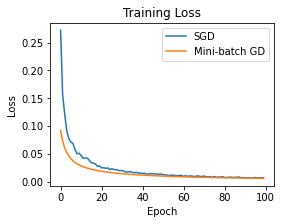

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(4, 3))
plt.plot(sgd_train_history['loss'], label='SGD')
plt.plot(mbgd_train_history['loss'], label='Mini-batch GD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

##### Please run the following cell to plot the validation metrics curve for SGD and Mini-batch GD

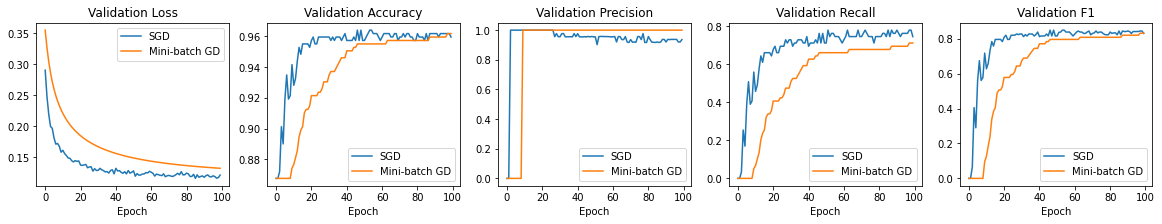

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for i, key in enumerate(sgd_valid_history.keys()):
    sgd_vals, mbgd_vals = sgd_valid_history[key], mbgd_valid_history[key]
    ax = axes[i]
    ax.plot(sgd_vals, label='SGD')
    ax.plot(mbgd_vals, label='Mini-batch GD')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_title('Validation ' + key.capitalize())
plt.show()

# 3. Conclusion 

Provide an analysis for all the results

MBGD metrics: 

valid_accuracy: 0.9619 - valid_precision: 1.0000 - valid_recall: 0.7119 - 
valid_f1: 0.8317

SGD metrics:


valid_accuracy: 0.9596 - valid_precision: 0.9362 - valid_recall: 0.7458 - valid_f1: 0.8302



1. We find that accuracy, recall and precision scores are quite similar in both sgd and mbgd models.
2. As seen in the training loss curve, mbgd is smoother compared to sgd.
3. Lower validation loss is observed in sgd.
4. The dataset is heavily imbalanced (spam:ham ratio is very low)